In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import gzip
import os
import requests
from anndata import AnnData
import scanpy as sc
from scipy import stats
import copy
import pickle
seed=314159
device='cuda'
from GPerturb_model_1 import *

# Load TCells data

In [2]:
my_conditioner = pd.read_csv('./data/TCells_data/TCells_perturbation_mat.csv')
my_conditioner = my_conditioner.drop('NonTarget', axis=1)  # TODO: or retaining it
cond_name = list(my_conditioner.columns)
my_conditioner = torch.tensor(my_conditioner.to_numpy() * 1.0, dtype=torch.float)

my_observation = pd.read_csv('./data/TCells_data/TCells_dev_filtered_raw.csv')
print(my_observation.shape)
gene_name = list(my_observation.columns)
my_observation = torch.tensor(my_observation.to_numpy() * 1.0, dtype=torch.float)

gene_name_lookup = pd.read_csv('./data/TCells_data/TCells_unfiltered_gene_lookup.csv', index_col=0)
gene_name_lookup = {gene_name_lookup.iloc[i].unfiltered_genes: gene_name_lookup.iloc[i].feature_name_lookup_unfiltered for i in range(gene_name_lookup.shape[0])}
gene_name = [gene_name_lookup[i] for i in gene_name]

my_cell_info = pd.read_csv('./data/TCells_data/TCells_cell_information.csv', index_col=0)
my_cell_info = my_cell_info[['lib_size', 'umi_count', 'percent_mt', 'doner', 'stimulated']]
my_cell_info.umi_count = my_cell_info.umi_count/my_cell_info.lib_size
my_cell_info.lib_size = np.log(my_cell_info.lib_size)
cell_info_names = list(my_cell_info.columns)
my_cell_info = torch.tensor(my_cell_info.to_numpy() * 1.0, dtype=torch.float)
stimulate_idx = my_cell_info[:, 4] == 0.
my_cell_info = my_cell_info[:, :4]

(24955, 6000)


# Specify and train Gaussian GPerturb

In [10]:
# specify model architecture
my_observation_0, my_cell_info_0, my_conditioner_0 = my_observation[stimulate_idx], my_cell_info[stimulate_idx], my_conditioner[stimulate_idx]
output_dim = my_observation_0.shape[1]
sample_size = my_observation_0.shape[0]
hidden_node = 700  
hidden_layer = 4
conditioner_dim = my_conditioner_0.shape[1]
cell_info_dim = my_cell_info_0.shape[1]
tau = torch.tensor(1.).to(device)  # Gumble softmax hyperparameter

# define the Gaussian GPerturb model
parametric_model_0 = GPerturb_Gaussian(conditioner_dim=conditioner_dim, output_dim=output_dim, base_dim=cell_info_dim,
                                     data_size=sample_size, hidden_node=hidden_node, hidden_layer_1=hidden_layer,
                                     hidden_layer_2=hidden_layer, tau=tau)
parametric_model_0 = parametric_model_0.to(device)
# train the model from scratch
# parametric_model_0.GPerturb_train(epoch=200, observation=my_observation_0, cell_info=my_cell_info_0, perturbation=my_conditioner_0, device=device)

# load pre-trained GPerturb model
parametric_model_0 = parametric_model_1.to('cpu')
parametric_model_0.load_state_dict(torch.load('GPerturb_TCells_Gaussian_cond0_3.pt'))

<All keys matched successfully>

In [11]:
# specify model architecture
my_observation_1, my_cell_info_1, my_conditioner_1 = my_observation[~stimulate_idx], my_cell_info[~stimulate_idx], my_conditioner[~stimulate_idx]
output_dim = my_observation_1.shape[1]
sample_size = my_observation_1.shape[0]
hidden_node = 700  
hidden_layer = 4
conditioner_dim = my_conditioner_1.shape[1]
cell_info_dim = my_cell_info_1.shape[1]
tau = torch.tensor(1.).to(device)  # Gumble softmax hyperparameter

# define the Gaussian GPerturb model
parametric_model_1 = GPerturb_Gaussian(conditioner_dim=conditioner_dim, output_dim=output_dim, base_dim=cell_info_dim,
                                     data_size=sample_size, hidden_node=hidden_node, hidden_layer_1=hidden_layer,
                                     hidden_layer_2=hidden_layer, tau=tau)
parametric_model_1 = parametric_model_1.to(device)
# train the model from scratch
# parametric_model_1.GPerturb_train(epoch=200, observation=my_observation_1, cell_info=my_cell_info_1, perturbation=my_conditioner_1, device=device)

# load pre-trained GPerturb model
parametric_model_1 = parametric_model_1.to('cpu')
parametric_model_1.load_state_dict(torch.load('GPerturb_TCells_Gaussian_cond1_3.pt'))

<All keys matched successfully>

In [16]:
# compute from fitted model
unique_conditions = torch.unique(my_conditioner_0, dim=0)
perturb_level, _, _, _, logit_p, _, _ = parametric_model_0(unique_conditions, None)
estimated_inclusion_prob = F.sigmoid(logit_p).detach().cpu().numpy()
estimated_inclusion = estimated_inclusion_prob > .5
my_gene_name = np.array(gene_name)[estimated_inclusion.sum(axis=0) > 0]
estimated_inclusion_prob = estimated_inclusion_prob[:, estimated_inclusion.mean(axis=0) > 0]
estimated_pert = perturb_level.detach().cpu().numpy() * estimated_inclusion
estimated_pert = estimated_pert[:, estimated_inclusion.mean(axis=0) > 0]
top_gene = np.argsort((estimated_pert**2).sum(axis=0))[::-1][:30]
estimated_pert_0 = estimated_pert[1:, top_gene]
my_gene_name_0 = my_gene_name[top_gene]

# load from pre-computed
# estimated_pert_0 = pd.read_csv('./GPerturb_vis_data/perturb_level_TCells_unstimulated.csv').to_numpy()[1:, :]
# my_gene_name_0 = list(pd.read_csv('./GPerturb_vis_data/top_gene_TCells_unstimulated.csv').to_numpy().ravel())

unique_conditions = unique_conditions.numpy()
my_yticks = ['' for _ in range(unique_conditions.shape[0])]
for i in range(unique_conditions.shape[0]):
    if np.all(unique_conditions[i] == 0):
        my_yticks[i] = 'Non Targeting'
    else:
        my_yticks[i] = np.array(cond_name)[unique_conditions[i] == 1][0] + '_N'
my_yticks_0 = copy.copy(my_yticks[1:])



# compute from fitted model
unique_conditions = torch.unique(my_conditioner_1, dim=0)
perturb_level, _, _, _, logit_p, _, _ = parametric_model_1(unique_conditions, None)
estimated_inclusion_prob = F.sigmoid(logit_p).detach().cpu().numpy()
estimated_inclusion = estimated_inclusion_prob > .5
my_gene_name = np.array(gene_name)[estimated_inclusion.sum(axis=0) > 0]
estimated_inclusion_prob = estimated_inclusion_prob[:, estimated_inclusion.mean(axis=0) > 0]
estimated_pert = perturb_level.detach().cpu().numpy() * estimated_inclusion
estimated_pert = estimated_pert[:, estimated_inclusion.mean(axis=0) > 0]
top_gene = np.argsort((estimated_pert**2).sum(axis=0))[::-1][:30]
estimated_pert_1 = estimated_pert[1:, top_gene]
my_gene_name_1 = my_gene_name[top_gene]

# load from pre-computed
# estimated_pert_1 = pd.read_csv('./GPerturb_vis_data/perturb_level_TCells_stimulated.csv').to_numpy()[1:, :]
# my_gene_name_1 = list(pd.read_csv('./GPerturb_vis_data/top_gene_TCells_stimulated.csv').to_numpy().ravel())
unique_conditions = unique_conditions.numpy()
my_yticks = ['' for _ in range(unique_conditions.shape[0])]
for i in range(unique_conditions.shape[0]):
    if np.all(unique_conditions[i] == 0):
        my_yticks[i] = 'Non Targeting'
    else:
        my_yticks[i] = np.array(cond_name)[unique_conditions[i] == 1][0] + '_S'
my_yticks_1 = copy.copy(my_yticks[1:])


estimated_pert_0 = pd.DataFrame(estimated_pert_0)
estimated_pert_0.columns = my_gene_name_0
estimated_pert_0.index = my_yticks_0

estimated_pert_1 = pd.DataFrame(estimated_pert_1)
estimated_pert_1.columns = my_gene_name_1
estimated_pert_1.index = my_yticks_1

estimated_pert = pd.concat([estimated_pert_0, estimated_pert_1], axis=0)
estimated_pert.fillna(0, inplace=True)
estimated_pert = estimated_pert.sort_index()
my_gene_name = np.array(list(estimated_pert.columns))
my_yticks = list(estimated_pert.index)
estimated_pert = estimated_pert.to_numpy()
sort_gene = np.argsort((estimated_pert**2).sum(axis=0))[::-1]
estimated_pert = estimated_pert[:, sort_gene]
my_gene_name = my_gene_name[sort_gene]

# Fig 7

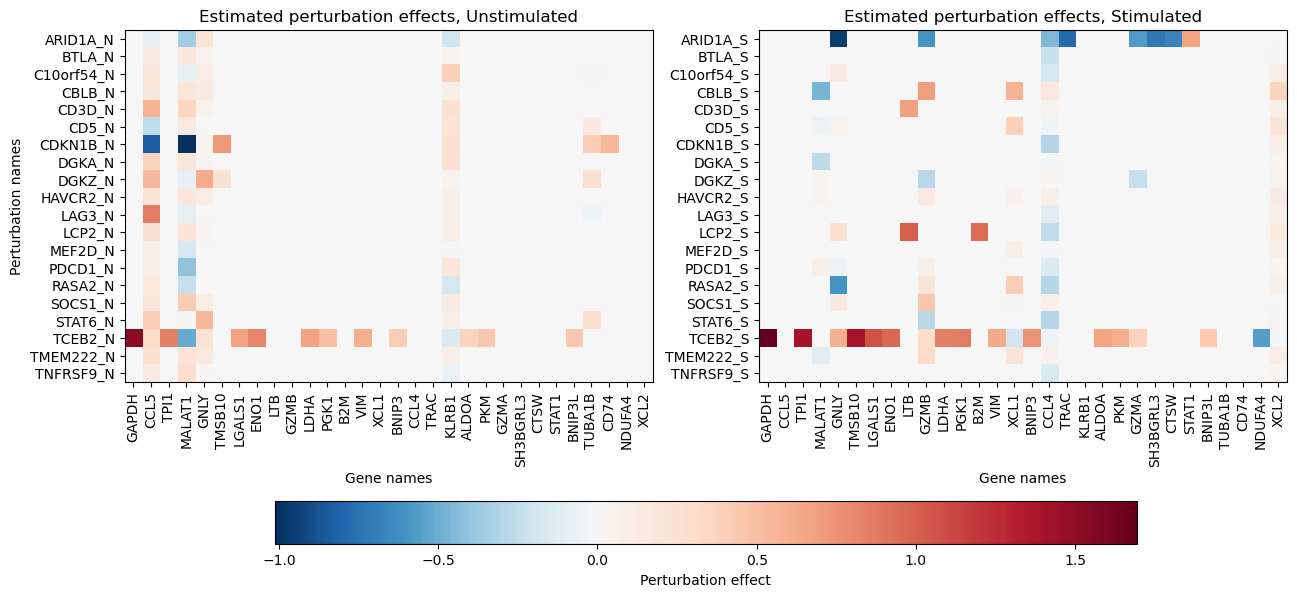

In [17]:
fig2, axes2 = plt.subplots(1,2)
negatives = np.min(estimated_pert)
positives = np.max(estimated_pert)
num_neg_colors = int(256 / (positives - negatives) * (-negatives))
num_pos_colors = 256 - num_neg_colors
cmap_BuRd = plt.cm.RdBu_r
colors_2neg_4pos = [cmap_BuRd(0.5*c/num_neg_colors) for c in range(num_neg_colors)] +\
                   [cmap_BuRd(1-0.5*c/num_pos_colors) for c in range(num_pos_colors)][::-1]
cmap_2neg_4pos_1 = colors.LinearSegmentedColormap.from_list('cmap_2neg_4pos', colors_2neg_4pos, N=256)
cmap_2neg_4pos_2 = colors.LinearSegmentedColormap.from_list('cmap_2neg_4pos', colors_2neg_4pos, N=256)

im = axes2[0].imshow(estimated_pert[::2][:, :30], vmin=negatives, vmax = positives, cmap=cmap_2neg_4pos_1)
axes2[0].set_xticks(np.arange(len(my_gene_name[:30])), my_gene_name[:30], rotation=90)
axes2[0].set_yticks(np.arange(len(my_yticks[::2])), my_yticks[::2])
axes2[0].set_ylabel('Perturbation names')
axes2[0].set_xlabel('Gene names')
axes2[0].set_title('Estimated perturbation effects, Unstimulated')
axes2[0].set_aspect('equal')

im = axes2[1].imshow(estimated_pert[1::2][:, :30], vmin=negatives, vmax = positives, cmap=cmap_2neg_4pos_2)
axes2[1].set_xticks(np.arange(len(my_gene_name[:30])), my_gene_name[:30], rotation=90)
axes2[1].set_yticks(np.arange(len(my_yticks[1::2])), my_yticks[1::2])
axes2[1].set_ylabel('')
axes2[1].set_xlabel('Gene names')
axes2[1].set_title('Estimated perturbation effects, Stimulated')
axes2[1].set_aspect('equal')
cbar = fig2.colorbar(im, ax=axes2, orientation="horizontal", pad=0.22, fraction=0.08)
cbar.ax.set_xlabel('Perturbation effect')
fig2.set_size_inches(15, 7)
# plt.savefig('./GPerturb_vis/TCells_GPerturb_heatmap_3.png', dpi=300)

# Fig 8

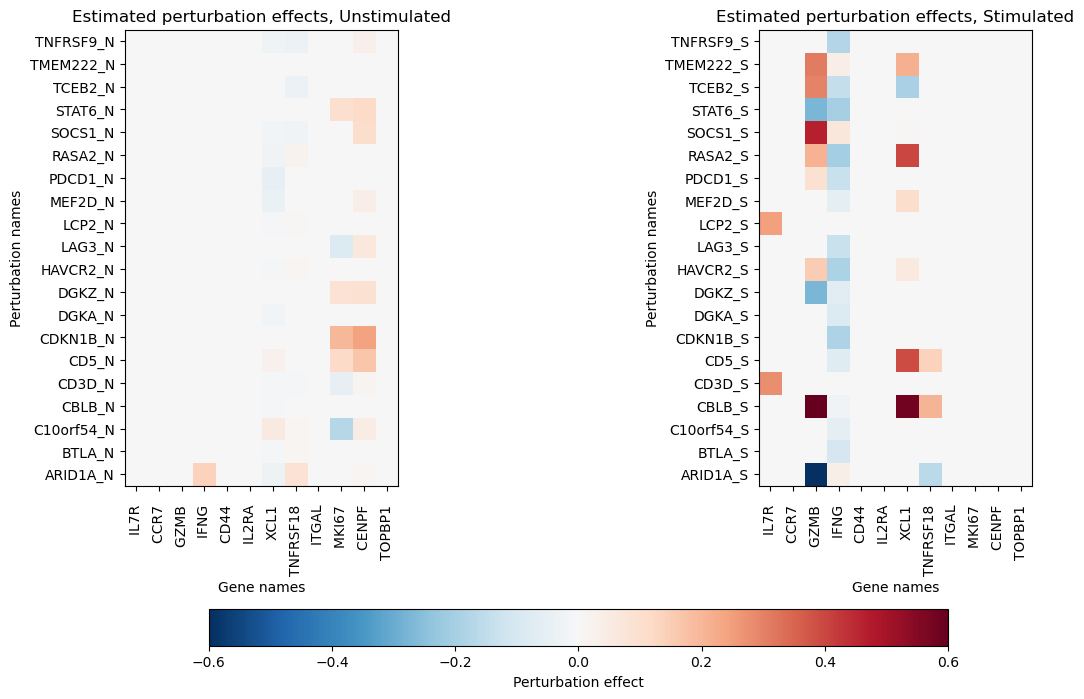

In [22]:
marker_genes = ['IL7R', 'CCR7', 'GZMB', 'IFNG', 'CD44', 'IL2RA', 'XCL1', 'TNFRSF18', 'ITGAL', 'MKI67', 'CENPF', 'TOPBP1']
# compute from model
# unique_conditions = torch.unique(my_conditioner_0, dim=0)
# perturb_level, _, _, _, logit_p, _, _ = parametric_model_0(unique_conditions, None)
# estimated_inclusion_prob = F.sigmoid(logit_p).detach().cpu().numpy()
# estimated_inclusion = estimated_inclusion_prob > .5
# estimated_pert = perturb_level.detach().cpu().numpy() * estimated_inclusion
# estimated_pert = estimated_pert[:, [gene_name.index(i) for i in marker_genes]]
# unique_conditions = unique_conditions.numpy()

# load precomputed
estimated_pert = pd.read_csv('./GPerturb_vis_data/perturb_level_TCells_unstimulated_marker.csv').to_numpy()

my_yticks = ['' for _ in range(unique_conditions.shape[0])]
for i in range(unique_conditions.shape[0]):
    if np.all(unique_conditions[i] == 0):
        my_yticks[i] = 'Non Targeting'
    else:
        my_yticks[i] = np.array(cond_name)[unique_conditions[i] == 1][0] + '_N'

estimated_pert_0_marker = estimated_pert[1:, :]*1.0
my_gene_name_0_marker = [i + '  ' for i in marker_genes]
my_yticks_0_marker = copy.copy(my_yticks[1:])

# compute from model
# unique_conditions = torch.unique(my_conditioner_1, dim=0)
# perturb_level, _, _, _, logit_p, _, _ = parametric_model_1(unique_conditions, None)
# estimated_inclusion_prob = F.sigmoid(logit_p).detach().cpu().numpy()
# estimated_inclusion = estimated_inclusion_prob > .5
# estimated_pert = perturb_level.detach().cpu().numpy() * estimated_inclusion
# estimated_pert = estimated_pert[:, [gene_name.index(i) for i in marker_genes]]
# unique_conditions = unique_conditions.numpy()

# load from precomputed
estimated_pert = pd.read_csv('./GPerturb_vis_data/perturb_level_TCells_stimulated_marker.csv').to_numpy()

my_yticks = ['' for _ in range(unique_conditions.shape[0])]
for i in range(unique_conditions.shape[0]):
    if np.all(unique_conditions[i] == 0):
        my_yticks[i] = 'Non Targeting'
    else:
        my_yticks[i] = np.array(cond_name)[unique_conditions[i] == 1][0] + '_S'

estimated_pert_1_marker = estimated_pert[1:, :]*1.0
my_gene_name_1_marker = [i + '  ' for i in marker_genes]
my_yticks_1_marker = copy.copy(my_yticks[1:])

fig2, axes2 = plt.subplots(1,2)
negatives = np.min([estimated_pert_1_marker.min(), estimated_pert_0_marker.min()])
positives = np.max([estimated_pert_1_marker.max(), estimated_pert_0_marker.max()])
num_neg_colors = int(256 / (positives - negatives) * (-negatives))
num_pos_colors = 256 - num_neg_colors
cmap_BuRd = plt.cm.RdBu_r
colors_2neg_4pos = [cmap_BuRd(0.5*c/num_neg_colors) for c in range(num_neg_colors)] +\
                   [cmap_BuRd(1-0.5*c/num_pos_colors) for c in range(num_pos_colors)][::-1]
cmap_2neg_4pos_1 = colors.LinearSegmentedColormap.from_list('cmap_2neg_4pos', colors_2neg_4pos, N=256)
cmap_2neg_4pos_2 = colors.LinearSegmentedColormap.from_list('cmap_2neg_4pos', colors_2neg_4pos, N=256)

im = axes2[0].imshow(estimated_pert_0_marker, vmin=-0.6, vmax = 0.6, cmap='RdBu_r')
axes2[0].set_xticks(np.arange(len(my_gene_name_0_marker)), my_gene_name_0_marker, rotation=90)
axes2[0].set_yticks(np.arange(len(my_yticks_0_marker)), my_yticks_0_marker)
axes2[0].set_ylabel('Perturbation names')
axes2[0].set_xlabel('Gene names')
axes2[0].set_title('Estimated perturbation effects, Unstimulated')
axes2[0].set_aspect('equal')

axes2[1].imshow(estimated_pert_1_marker, vmin=-0.6, vmax = 0.6, cmap='RdBu_r')
axes2[1].set_xticks(np.arange(len(my_gene_name_1_marker)), my_gene_name_1_marker, rotation=90)
axes2[1].set_yticks(np.arange(len(my_yticks_1_marker)), my_yticks_1_marker)
axes2[1].set_ylabel('Perturbation names')
axes2[1].set_xlabel('Gene names')
axes2[1].set_title('Estimated perturbation effects, Stimulated')
axes2[1].set_aspect('equal')
# ticks = np.append(np.arange(-1.5, 0, 0.5), np.arange(0, 5.101, 1.7))
# fig2.colorbar(im, ax=axes2, ticks=ticks)
cbar = fig2.colorbar(im, ax=axes2, orientation="horizontal", pad=0.2, fraction=0.06)
cbar.ax.set_xlabel('Perturbation effect')
fig2.set_size_inches(15, 8)
# plt.savefig('./GPerturb_vis/TCells_GPerturb_heatmap_markers_3.png', dpi=300)

# Fig 9

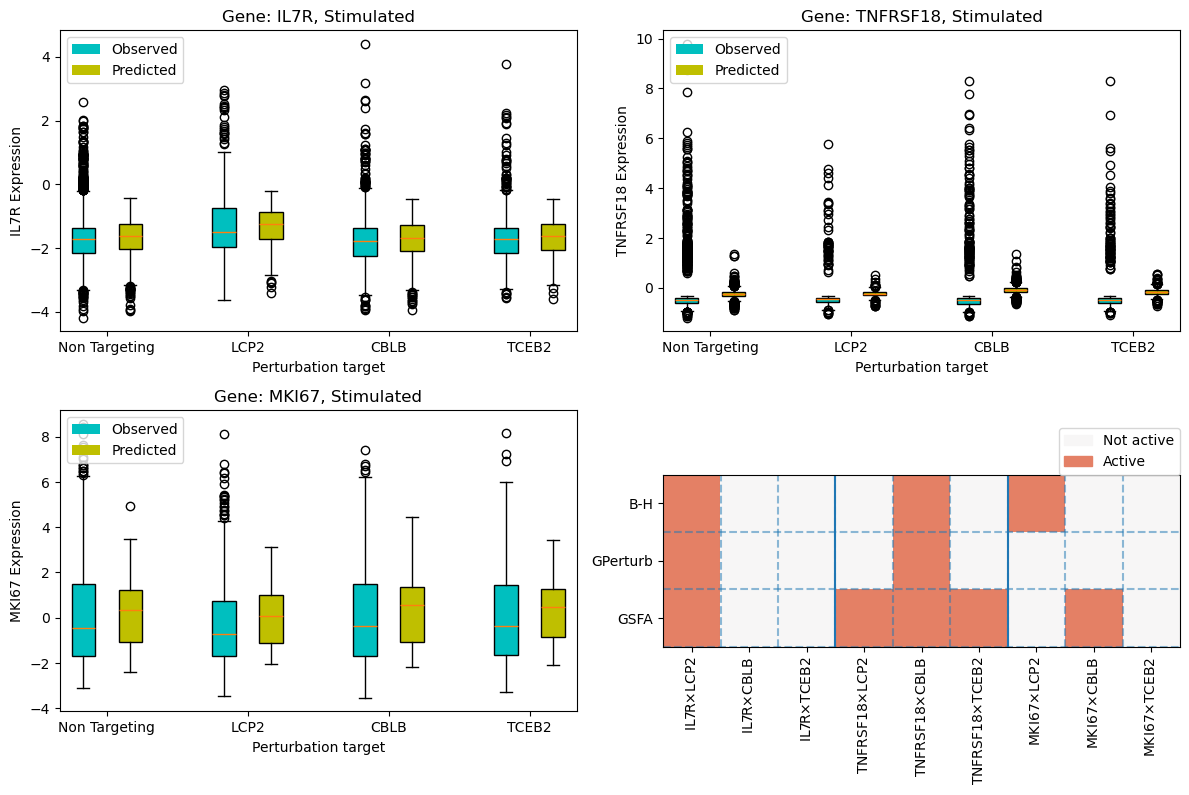

In [23]:
# compute from model
fitted_vals_1 = Gaussian_estimates(model=parametric_model_1, obs=my_observation_1, 
                                   cond=my_conditioner_1, cell_info=my_cell_info_1)
fitted_vals = fitted_vals_1['pert_mean']
# load from precomputed
# fitted_vals = pd.read_csv('./GPerturb_vis_data/fitted_TCells_stimulated.csv').to_numpy()


gene_list = ['IL7R', 'TNFRSF18', 'MKI67']
pert_1 = 'LCP2'
pert_2 = 'CBLB'
pert_3 = 'TCEB2'

unique_conditions = torch.unique(my_conditioner_1, dim=0)
unique_conditions = unique_conditions.numpy()
my_yticks = ['' for _ in range(unique_conditions.shape[0])]
ref_id = 0
for i in range(unique_conditions.shape[0]):
    if np.all(unique_conditions[i] == 0):
        my_yticks[i] = 'Non Targeting'
        ref_id = i
    else:
        my_yticks[i] = np.array(cond_name)[unique_conditions[i] == 1][0]
pret_id_1 = cond_name.index(pert_1)
pret_id_2 = cond_name.index(pert_2)
pret_id_3 = cond_name.index(pert_3)

color = ['c', 'y', 'c', 'y', 'c', 'y', 'c', 'y']
import matplotlib.patches as mpatches
f, a = plt.subplots(ncols=2, nrows=2)
pvals=np.zeros(0)
for idx, i in enumerate(gene_list):
    CHD2_pert = my_observation_1[my_conditioner_1[:, pret_id_1] == 1., gene_name.index(i)].numpy()
    CHD2_pert_est = fitted_vals[my_conditioner_1[:, pret_id_1] == 1., gene_name.index(i)]

    PTEN_pert = my_observation_1[my_conditioner_1[:, pret_id_2] == 1., gene_name.index(i)].numpy()
    PTEN_pert_est = fitted_vals[my_conditioner_1[:, pret_id_2] == 1., gene_name.index(i)]

    SETD5_pert = my_observation_1[my_conditioner_1[:, pret_id_3] == 1., gene_name.index(i)].numpy()
    SETD5_pert_est = fitted_vals[my_conditioner_1[:, pret_id_3] == 1., gene_name.index(i)]

    base = my_observation_1[my_conditioner_1.mean(1) == 0., gene_name.index(i)].numpy()
    base_est = fitted_vals[my_conditioner_1.mean(1) == 0., gene_name.index(i)]

    pvals = np.concatenate((pvals, np.array([stats.ttest_ind(CHD2_pert, base, equal_var=False)[1],
                                   stats.ttest_ind(PTEN_pert, base, equal_var=False)[1],
                                   stats.ttest_ind(SETD5_pert, base, equal_var=False)[1]])))
    pos = [1, 2, 4, 5, 7, 8, 10, 11]
    label = ['Non Targeting', 'LCP2', 'CBLB', 'TCEB2']
    data = [base, base_est, CHD2_pert, CHD2_pert_est, PTEN_pert, PTEN_pert_est, SETD5_pert, SETD5_pert_est]
    bxp = a[idx//2, idx%2].boxplot(data, positions=pos, patch_artist = True)
    a[idx//2, idx%2].set_xticks(ticks=[1.5, 4.5, 7.5, 10.5], labels=label)
    a[idx//2, idx%2].set_title('Gene: ' + i + ', Stimulated')
    a[idx//2, idx%2].set_ylabel(i + ' Expression')
    a[idx//2, idx%2].set_xlabel('Perturbation target')
    legend_elements = [mpatches.Patch(facecolor=color[0], label='Observed'),
                       mpatches.Patch(facecolor=color[1], label='Predicted')]
    for boxes, colo in zip(bxp['boxes'], color):
        boxes.set_facecolor(colo)
    a[idx//2, idx%2].legend(handles = legend_elements, loc='upper left')

adj_p = 1.0*(stats.false_discovery_control(pvals)<0.05)
BSAPR = np.array([1,0,0,0,1,0,0,0,0])
GSFA = np.array([1,0,0,1,1,1,0,1,0])
im=a[1,1].imshow(np.array([adj_p, BSAPR, GSFA]), cmap='RdBu_r', vmax=2, vmin=-2)
a[1,1].set_xticks(np.arange(9), [i + r'$\times$' + j for i in gene_list for j in [pert_1, pert_2, pert_3]], rotation=90)
a[1,1].set_yticks(np.arange(3), ['B-H', 'GPerturb', 'GSFA'])
a[1,1].axvline(x=2.5)
a[1,1].axvline(x=5.5)
for i in range(8):
    a[1, 1].axvline(x=i + .5, alpha=0.5, linestyle='--')
for i in range(3):
    a[1, 1].axhline(y=i + .5, alpha=0.5, linestyle='--')

a[1,1].grid(linestyle='--', linewidth=1., which='minor')
values=np.array([0,1])
l = ['Not active', 'Active']
colors = [im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color
patches = [ mpatches.Patch(color=colors[i], label=l[i]) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1., 1), loc=4, borderaxespad=0. )

f.set_size_inches(12, 8)
f.tight_layout()
# plt.savefig('./GPerturb_vis/TCells_stimulated_box_3.png', dpi=300)

# Fig 10

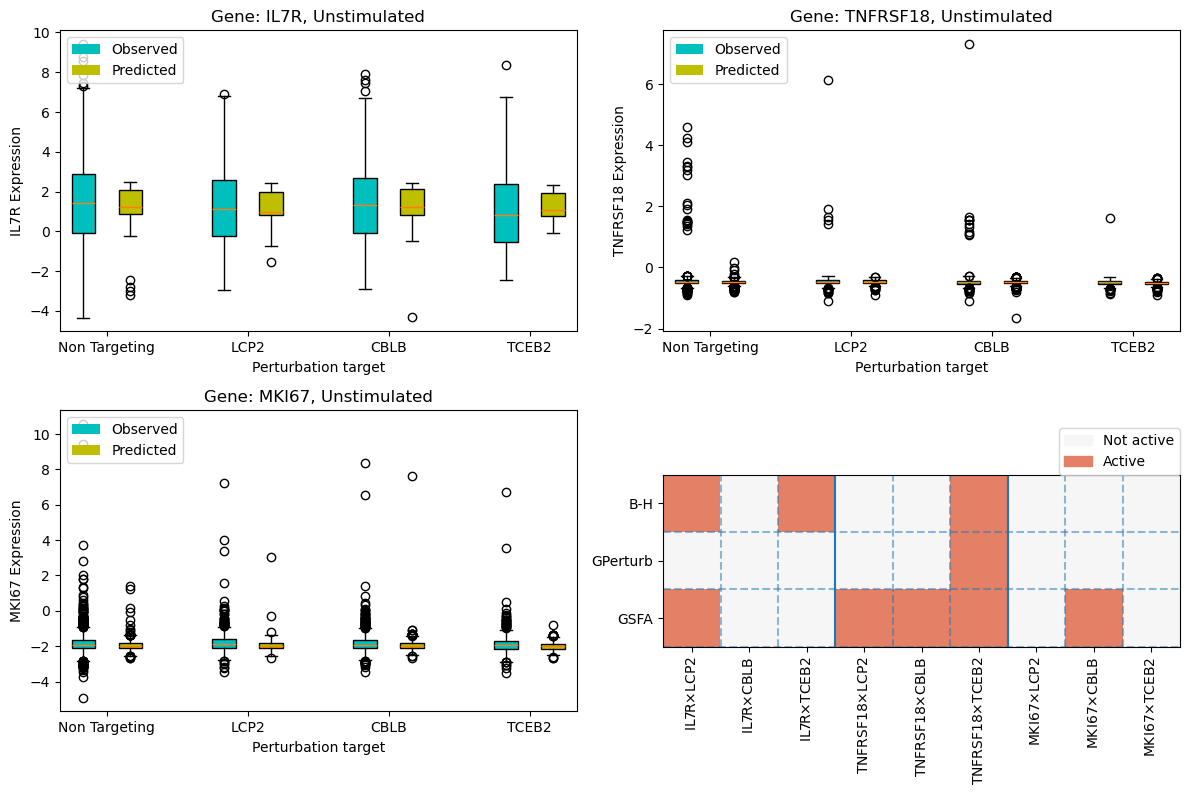

In [24]:
# compute from model
fitted_vals_0 = Gaussian_estimates(model=parametric_model_0, obs=my_observation_0, 
                                   cond=my_conditioner_0, cell_info=my_cell_info_0)
fitted_vals = fitted_vals_0['pert_mean']
# load from precomputed
# fitted_vals = pd.read_csv('./GPerturb_vis_data/fitted_TCells_unstimulated.csv').to_numpy()

gene_list = ['IL7R', 'TNFRSF18', 'MKI67']
pert_1 = 'LCP2'
pert_2 = 'CBLB'
pert_3 = 'TCEB2'

unique_conditions = torch.unique(my_conditioner_0, dim=0)
unique_conditions = unique_conditions.numpy()
my_yticks = ['' for _ in range(unique_conditions.shape[0])]
ref_id = 0
for i in range(unique_conditions.shape[0]):
    if np.all(unique_conditions[i] == 0):
        my_yticks[i] = 'Non Targeting'
        ref_id = i
    else:
        my_yticks[i] = np.array(cond_name)[unique_conditions[i] == 1][0]
pret_id_1 = cond_name.index(pert_1)
pret_id_2 = cond_name.index(pert_2)
pret_id_3 = cond_name.index(pert_3)

color = ['c', 'y', 'c', 'y', 'c', 'y', 'c', 'y']
import matplotlib.patches as mpatches
f, a = plt.subplots(ncols=2, nrows=2)
pvals=np.zeros(0)
for idx, i in enumerate(gene_list):
    CHD2_pert = my_observation_0[my_conditioner_0[:, pret_id_1] == 1., gene_name.index(i)].numpy()
    CHD2_pert_est = fitted_vals[my_conditioner_0[:, pret_id_1] == 1., gene_name.index(i)]

    PTEN_pert = my_observation_0[my_conditioner_0[:, pret_id_2] == 1., gene_name.index(i)].numpy()
    PTEN_pert_est = fitted_vals[my_conditioner_0[:, pret_id_2] == 1., gene_name.index(i)]

    SETD5_pert = my_observation_0[my_conditioner_0[:, pret_id_3] == 1., gene_name.index(i)].numpy()
    SETD5_pert_est = fitted_vals[my_conditioner_0[:, pret_id_3] == 1., gene_name.index(i)]

    base = my_observation_0[my_conditioner_0.mean(1) == 0., gene_name.index(i)].numpy()
    base_est = fitted_vals[my_conditioner_0.mean(1) == 0., gene_name.index(i)]

    pvals = np.concatenate((pvals, np.array([stats.ttest_ind(CHD2_pert, base, equal_var=False)[1],
                                   stats.ttest_ind(PTEN_pert, base, equal_var=False)[1],
                                   stats.ttest_ind(SETD5_pert, base, equal_var=False)[1]])))
    pos = [1, 2, 4, 5, 7, 8, 10, 11]
    label = ['Non Targeting', 'LCP2', 'CBLB', 'TCEB2']
    data = [base, base_est, CHD2_pert, CHD2_pert_est, PTEN_pert, PTEN_pert_est, SETD5_pert, SETD5_pert_est]
    bxp = a[idx//2, idx%2].boxplot(data, positions=pos, patch_artist = True)
    a[idx//2, idx%2].set_xticks(ticks=[1.5, 4.5, 7.5, 10.5], labels=label)
    a[idx//2, idx%2].set_title('Gene: ' + i + ', Unstimulated')
    a[idx//2, idx%2].set_ylabel(i + ' Expression')
    a[idx//2, idx%2].set_xlabel('Perturbation target')
    legend_elements = [mpatches.Patch(facecolor=color[0], label='Observed'),
                       mpatches.Patch(facecolor=color[1], label='Predicted')]
    for boxes, colo in zip(bxp['boxes'], color):
        boxes.set_facecolor(colo)
    a[idx//2, idx%2].legend(handles = legend_elements, loc='upper left')

adj_p = 1.0*(stats.false_discovery_control(pvals)<0.05)
BSAPR = np.array([0,0,0,0,0,1,0,0,0])
GSFA =  np.array([1,0,0,1,1,1,0,1,0])
im=a[1,1].imshow(np.array([adj_p, BSAPR, GSFA]), cmap='RdBu_r', vmax=2, vmin=-2)
a[1,1].set_xticks(np.arange(9), [i + r'$\times$' + j for i in gene_list for j in [pert_1, pert_2, pert_3]], rotation=90)
a[1,1].set_yticks(np.arange(3), ['B-H', 'GPerturb', 'GSFA'])
a[1,1].axvline(x=2.5)
a[1,1].axvline(x=5.5)
for i in range(8):
    a[1, 1].axvline(x=i + .5, alpha=0.5, linestyle='--')
for i in range(3):
    a[1, 1].axhline(y=i + .5, alpha=0.5, linestyle='--')

a[1,1].grid(linestyle='--', linewidth=1., which='minor')
values=np.array([0,1])
l = ['Not active', 'Active']
colors = [im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color
patches = [ mpatches.Patch(color=colors[i], label=l[i]) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1., 1), loc=4, borderaxespad=0. )

f.set_size_inches(12, 8)
f.tight_layout()
# plt.savefig('./GPerturb_vis/TCells_unstimulated_box_3.png', dpi=300)

# Fig 3 Lower half

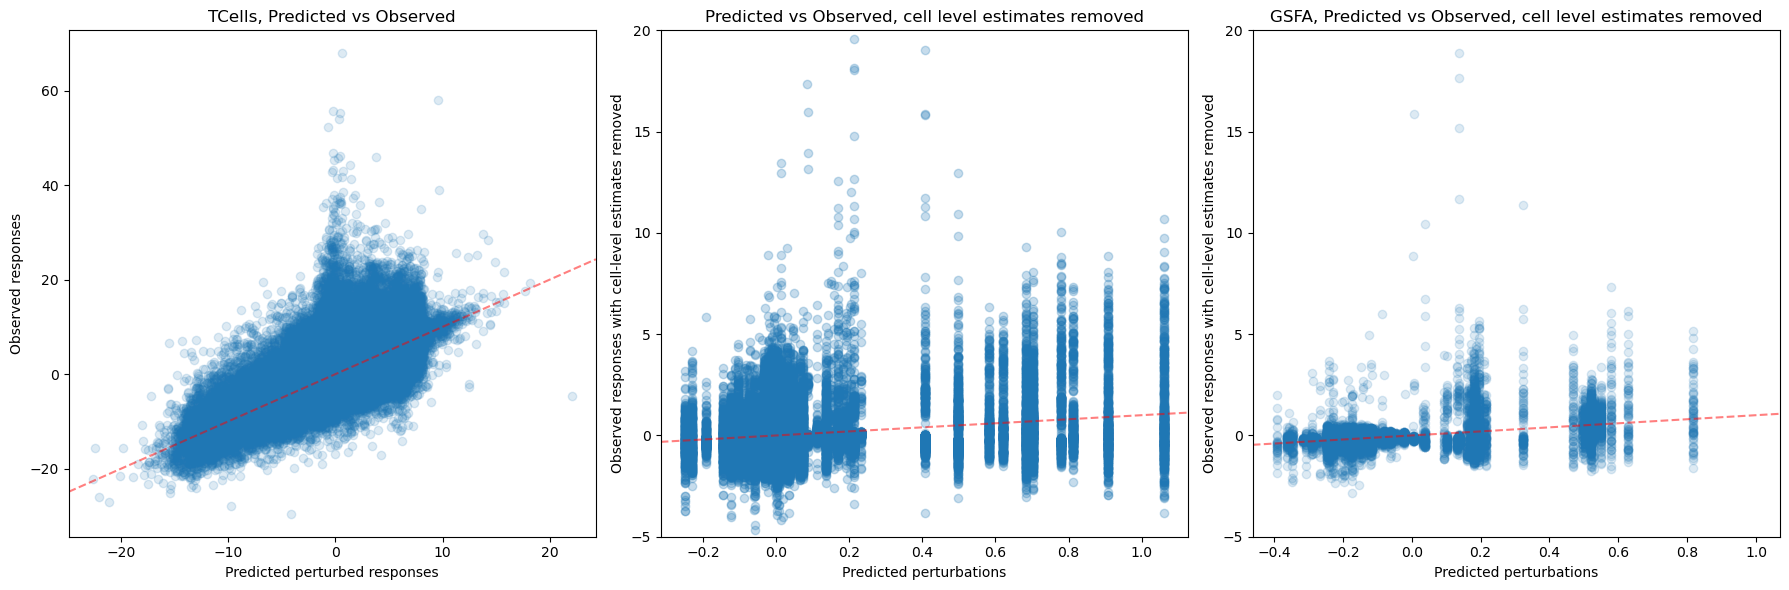

In [27]:
# compute from model
fitted_vals_0 = Gaussian_estimates(model=parametric_model_0, obs=my_observation_0[parametric_model_0.test_id], 
                                   cond=my_conditioner_0[parametric_model_0.test_id], cell_info=my_cell_info_0[parametric_model_0.test_id])
fitted_vals_1 = Gaussian_estimates(model=parametric_model_1, obs=my_observation_1[parametric_model_1.test_id], 
                                   cond=my_conditioner_1[parametric_model_1.test_id], cell_info=my_cell_info_1[parametric_model_1.test_id])
pert_mean_TCells = np.vstack((fitted_vals_0['pert_mean'] * 1.0, fitted_vals_1['pert_mean'] * 1.0))
obs_TCells = np.vstack((fitted_vals_0['obs'] * 1.0, fitted_vals_1['obs'] * 1.0))
pert_effect = np.vstack((fitted_vals_0['pert_effect'] * 1.0, fitted_vals_1['pert_effect'] * 1.0))
base_removed = np.vstack((fitted_vals_0['base_removed'] * 1.0, fitted_vals_1['base_removed'] * 1.0))
prob = np.vstack((fitted_vals_0['prob'] * 1.0, fitted_vals_1['prob'] * 1.0))


inclusion_TCells = prob > .95
normed_pert_effect_TCells = ((pert_effect - base_removed.mean(0)[None, :])/np.sqrt(base_removed.var(axis=0)[None, :]))[inclusion_TCells]
normed_pert_removed_TCells = ((base_removed - base_removed.mean(0)[None, :]) / np.sqrt(base_removed.var(axis=0)[None, :]))[inclusion_TCells]

# load from pre-computed
# pert_mean_TCells = pd.read_csv('pert_mean_TCells.csv').to_numpy().ravel()
# obs_TCells = pd.read_csv('obs_TCells.csv').to_numpy().ravel()
# normed_pert_effect_TCells = pd.read_csv('normed_pert_effect_TCells.csv').to_numpy().ravel()
# normed_pert_removed_TCells = pd.read_csv('normed_pert_removed_TCells.csv').to_numpy().ravel()
# GSFA_fit_TCells = pd.read_csv('GSFA_fit_TCells.csv').to_numpy().ravel()
# GSFA_obs_TCells = pd.read_csv('GSFA_obs_TCells.csv').to_numpy().ravel()


GSFA_fit_TCells = pd.read_csv('GSFA_fit_TCells.csv').to_numpy().ravel()
GSFA_obs_TCells = pd.read_csv('GSFA_obs_TCells.csv').to_numpy().ravel()

fig, axes = plt.subplots(1,3)  # plt.subplots(nrows=2, ncols=2)
axes[0].scatter(pert_mean_TCells, obs_TCells, alpha=0.15)
axes[0].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[0].set_xlabel('Predicted perturbed responses')
axes[0].set_ylabel('Observed responses')
axes[0].set_title('TCells, Predicted vs Observed')

axes[1].scatter(normed_pert_effect_TCells,
                   normed_pert_removed_TCells,
                            alpha=0.25)
axes[1].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[1].set_ylim(-5, 20)
axes[1].set_xlabel('Predicted perturbations')
axes[1].set_ylabel('Observed responses with cell-level estimates removed')
axes[1].set_title('Predicted vs Observed, cell level estimates removed')


axes[2].scatter(GSFA_fit_TCells, GSFA_obs_TCells, alpha=0.15)
axes[2].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[2].set_ylim(-5, 20)
axes[2].set_xlabel('Predicted perturbations')
axes[2].set_ylabel('Observed responses with cell-level estimates removed')
axes[2].set_title('GSFA, Predicted vs Observed, cell level estimates removed')
fig.set_size_inches(18, 6)
fig.tight_layout()